# Linear Regression to Predict NBA Player Salaries based on Stats

###### by Dotun Opasina

### Introduction
The goal of this project is to predict Nba Players salaries from 2017 - 2019 using linear regression model while performing data scraping and feature extractions.

In [1]:
## Include Libraries
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
from sklearn.preprocessing import StandardScaler
import numpy as np
import math

In [2]:
## Declare split and validate functions to be used later in the code
def split_and_validate(X,y,test=.25,random=3):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test, random_state=random)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    y_pred = lr_model.predict(X_val)

    residuals = y_val - y_pred
    

    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results:')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')
    
    return X_train, X_val, y_train, y_val, residuals, lr_model

## Step 1: Data Retrieving and Cleaning

In [3]:
onlyPlayerStats = pd.read_csv("NbaPlayerStats20172019.csv")

In [4]:
## Do Some Data Cleaning
onlyPlayerStats = onlyPlayerStats.rename(columns={'3P' : 'ThreePoints', 'PTS/G': 'PointsPerGame' })

onlyPlayerStats.describe()

,Age,MP,ThreePoints,AST,FG,FT,TOV,DRB,FGA,TRB,ORB,FTA,STL,BLK,PF,PointsPerGame,Salary
count,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1.422000e+03
mean,26.274965,20.104993,0.849930,1.938748,3.226231,1.395007,1.119339,2.773980,7.121167,3.603165,0.832911,1.830591,0.642827,0.396343,1.714416,8.695640,6.282043e+06
std,4.270868,9.080240,0.796339,1.785743,2.174433,1.362123,0.803895,1.857142,4.550271,2.485467,0.779983,1.669720,0.435366,0.426993,0.777079,6.050177,7.368601e+06
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.608000e+03
25%,23.000000,13.300000,0.200000,0.700000,1.600000,0.500000,0.525000,1.500000,3.700000,1.900000,0.300000,0.725000,0.300000,0.100000,1.200000,4.300000,1.312611e+06
50%,26.000000,20.000000,0.700000,1.400000,2.700000,1.000000,1.000000,2.400000,6.100000,3.100000,0.600000,1.300000,0.600000,0.300000,1.800000,7.300000,2.962860e+06
75%,29.000000,27.475000,1.300000,2.500000,4.400000,1.800000,1.500000,3.600000,9.800000,4.700000,1.100000,2.400000,0.900000,0.500000,2.200000,11.800000,9.000000e+06
max,42.000000,37.800000,5.100000,11.200000,10.800000,9.700000,5.700000,11.100000,24.500000,16.000000,5.400000,11.000000,2.400000,6.000000,4.400000,36.100000,3.745715e+07


In [5]:
### Remove Player Salaries that are Zero 
onlyPlayerStats.drop(onlyPlayerStats[onlyPlayerStats.Salary == 0].index, inplace=True)

### Since we are dealing with Salaries data, we perform a logarithmic transformation to make highly skewed distribution salary differinces less skewed

In [6]:
onlyPlayerStats["Salary_Log"] = np.log(onlyPlayerStats["Salary"])

## Step 2: Perform Initial Validation on initial data set

In [7]:
## Take out Name, Salary and Salary Logged and Season from our data and use the remaining data for
## our X value
## Select only the Salary logged as our Y
X, y = onlyPlayerStats.drop(['Name','Salary', 'Salary_Log','Season'],axis=1), onlyPlayerStats['Salary_Log']


In [8]:
## Do a split and validate of our original data
X_train, X_val, y_train, y_val, residuals, model = split_and_validate(X,y)


Validation R^2 score was: 0.42612028609801234
Feature coefficient results:
Age : 0.08
MP : 0.06
ThreePoints : 0.08
AST : 0.02
FG : 0.29
FT : 0.19
TOV : -0.06
DRB : -0.43
FGA : -0.06
TRB : 0.61
ORB : -0.67
FTA : -0.07
STL : -0.13
BLK : -0.17
PF : 0.11
PointsPerGame : -0.04


What we notice from the result above is there are many features that have negative relationships with the salary column so we need a way to pick what features are most important for our model

## Step 3: Perform Lasso algorithms for Feature selections

##### Standard Scale our Inputs

In [9]:
## We first use a standard scaler to scale the inputs
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
## Transform our X column
X_tr = std.transform(X_train.values)
X_te = std.transform(X_val.values)

##### Lasso Step

In [12]:
lassocv = LassoCV(cv=5, random_state=0) ## Initialize Lasso

In [14]:
lassocv.fit(X_tr, y_train) ## We fit our data

/Users/opasina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/opasina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/opasina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/opasina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective di

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=0, selection='cyclic',
    tol=0.0001, verbose=False)

In [16]:
lassocv.score(X_te, y_val) ## Our Lasso Score

0.4331577336227551

Text(0.5, 0, 'Alpha (log10)')

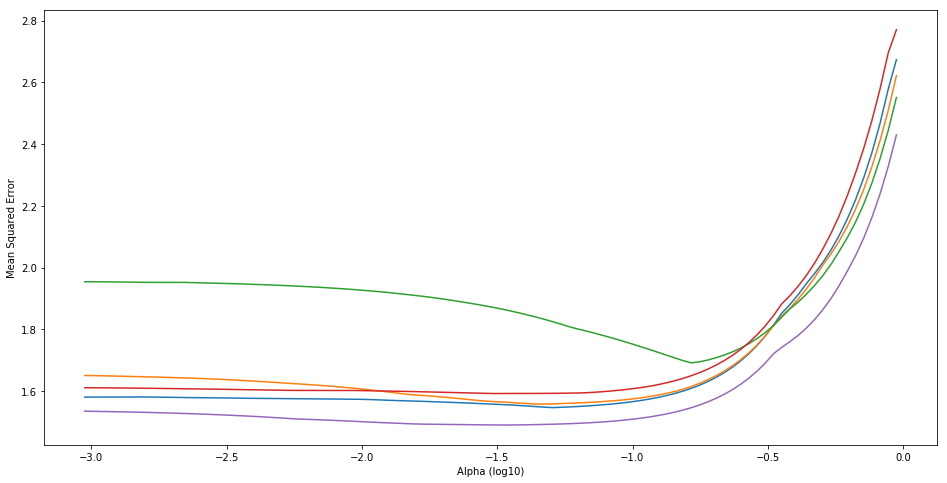

In [31]:
## Plot out the Lasso Alphas
plot.figure(figsize=(16, 8))
plot.plot(np.log10(lassocv.alphas_),lassocv.mse_path_)
plot.ylabel("Mean Squared Error")
plot.xlabel("Alpha (log10)")

##### Print out Columns to their Lasso Coefficients

In [18]:
columnList = list(zip(X.columns,lassocv.coef_))

print(columnList)

[('Age', 0.2664831766364393), ('MP', 0.48080219845698413), ('ThreePoints', 0.0), ('AST', 0.0), ('FG', 0.0), ('FT', 0.0), ('TOV', 0.0), ('DRB', 0.26304816412713483), ('FGA', 0.0), ('TRB', 0.0), ('ORB', 0.0), ('FTA', 0.0), ('STL', 0.0), ('BLK', 0.0), ('PF', 0.006711896757269426), ('PointsPerGame', 0.21123285019191615)]


So we see that most of our columns have a lasso coeefficients of 0 so we can remove them from our features list as they do not contribute any significant effect on our data

In [23]:
usefulColumns = [x[0] for x in columnList if x[1] != 0.0]

In [20]:
print(usefulColumns)

['Age', 'MP', 'DRB', 'PF', 'PointsPerGame']


## The Best Predictors on Salaries are:
    1. Age
    2. Minutes Played per Game
    3. Defensive Rebounds per Game
    4. Personal Fouls
    5. Average Points Per Game

In [22]:
## Split Data into X and Y to be used for validating Lasso
X, y = onlyPlayerStats[usefulColumns], onlyPlayerStats['Salary_Log']


In [25]:
## View Correlation of Input Data and Output
usefulColumns.append('Salary_Log')
onlyUsefulColumns = onlyPlayerStats[usefulColumns]

[Text(0.5, 0, 'Age'),
 Text(1.5, 0, 'Minutes Played'),
 Text(2.5, 0, 'Defensive Rebound'),
 Text(3.5, 0, 'Fouls'),
 Text(4.5, 0, 'Points'),
 Text(5.5, 0, 'Log of Salary')]

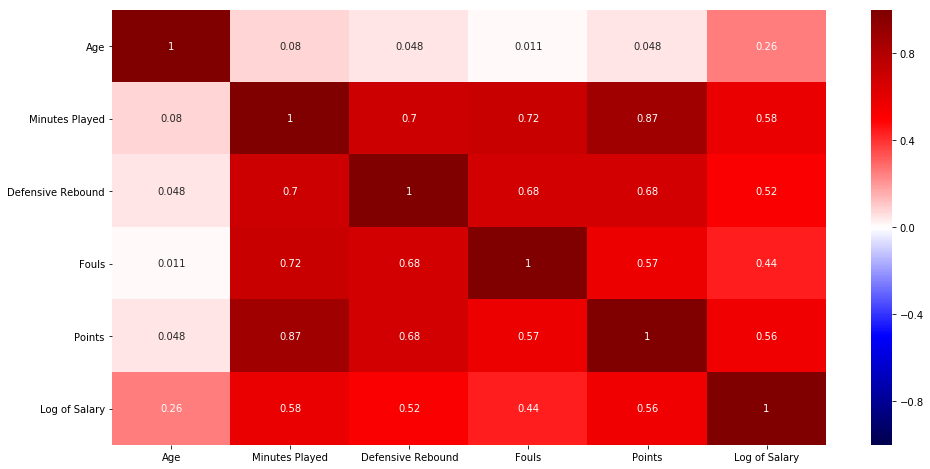

In [30]:
## Plot Correlation of Salary to Features

plot.figure(figsize=(16, 8))
snsPlot = sns.heatmap(onlyUsefulColumns.corr(), xticklabels=['Age', 'Minutes Played', 'Defensive Rebound', 'Fouls', 'Points', 'Log of Salary'], yticklabels=['Age', 'Minutes Played', 'Defensive Rebound', 'Fouls', 'Points', 'Log of Salary'],cmap="seismic", annot=True, vmin=-1, vmax=1)
snsPlot.set_xticklabels(snsPlot.get_xticklabels(), rotation = 0)

We notice that all the input are positively correlated with our salary so this makes our problem ideal for a Linear Regression

## STEP 4: PREDICTION USING FEATURES SELECTED BY LASSO

In [32]:
X_train, X_val, y_train, y_val, residuals, model = split_and_validate(X,y) ## Generated new Scores

y_pred = model.predict(X)

onlyPlayerStats["Salary_Log_predict"] = y_pred


Validation R^2 score was: 0.43864438613970036
Feature coefficient results:
Age : 0.08
MP : 0.05
DRB : 0.15
PF : 0.07
PointsPerGame : 0.04


In [33]:
onlyPlayerStats.head()

,Name,Age,MP,ThreePoints,AST,FG,FT,TOV,DRB,FGA,...,ORB,FTA,STL,BLK,PF,PointsPerGame,Salary,Season,Salary_Log,Salary_Log_predict
0,Giannis Antetokounmpo,24,32.8,0.7,5.9,10.0,6.9,3.7,10.3,17.3,...,2.2,9.5,1.3,1.5,3.2,27.7,24157304.0,NBA_2019,17.000097,17.290277
1,Khris Middleton,27,31.1,2.3,4.3,6.6,2.8,2.3,5.3,14.9,...,0.6,3.4,1.0,0.1,2.2,18.3,13000000.0,NBA_2019,16.380460,16.212891
2,Eric Bledsoe,29,29.1,1.6,5.5,6.0,2.3,2.1,3.6,12.4,...,1.1,3.0,1.5,0.4,2.0,15.9,15000000.0,NBA_2019,16.523561,15.897635
3,Brook Lopez,30,28.7,2.3,1.2,4.4,1.4,1.0,4.5,9.7,...,0.4,1.6,0.6,2.2,2.3,12.5,3382000.0,NBA_2019,15.033978,15.971340
4,Malcolm Brogdon,26,28.6,1.6,3.2,5.9,2.2,1.4,3.5,11.7,...,1.0,2.4,0.7,0.2,1.6,15.6,1544951.0,NBA_2019,14.250503,15.576392


So we have our predicted Salary in Logarithm but we need to do some inverse log transformation to get our specific players salary. We create a function for that below

In [35]:
'''
This function returns a dataframe containing a particular user, their stats, 
log of their actual and predicted salaries, and their actual and predicted salaries
'''
def getDataStatsSalary(onlyPlayerStats,usefulColumns,playerName):
    sortByPlayerStats = onlyPlayerStats.sort_values(by=['Name','Season'])

    ### Get Players, and Important Columns
    usefulColumns = ["Name"] + usefulColumns[0:5] + ["Season","Salary"] + [usefulColumns[5]] + ["Salary_Log_predict"]

    importedColumnSortedPlayers = sortByPlayerStats[usefulColumns]

    GiannisHistory = importedColumnSortedPlayers [importedColumnSortedPlayers["Name"] == playerName]

    arrayIndex = []
    for res in GiannisHistory["Salary_Log_predict"]:
        arrayIndex.append(math.exp(res))
    
    GiannisHistory["Salary_predicted"] = arrayIndex
    
    CompareData = GiannisHistory.drop(columns=["Salary_Log_predict", "Salary_Log"])
    
    return CompareData

## Step 5: Evaluate Results and Draw Insights

## Insights 1:
Victor Oladipo who won the most improved player in 2018 so an increase in his actual salary from $6.5 M to $ 21 M but my model he predicted he needs to be making less based on his stats. In particular, Victor's stats are lower in 2018 than 2019 because of an out of season injury he had. 

In [50]:
## Check for the most improved Player in 2017 and evaluate his growth
playerComparedStatsVictor = getDataStatsSalary(onlyPlayerStats,usefulColumns,"Victor Oladipo")
pd.options.display.float_format = '{:.2f}'.format
playerComparedStatsVictor 

/Users/opasina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Name,Age,MP,DRB,PF,PointsPerGame,Season,Salary,Salary_predicted
1260,Victor Oladipo,24,33.20,3.80,2.30,15.90,NBA_2017,6552960.00,6950453.18
555,Victor Oladipo,25,34.00,4.60,2.30,23.10,NBA_2018,21000000.00,12024670.29
64,Victor Oladipo,26,31.90,5.00,2.00,18.80,NBA_2019,21000000.00,10163521.21


## Insights 2:
Giannis Antetokounmpo who won the most improved player in 2017 and plays for the Bucks saw an increase in his actual salary from $2.9 M to $ 24 M but my model predicted that he needs to be making a lot more money because of the impact he making on his team.

Giannis personally cares more about building the franchise of the Bucks than making the most money from his team but we can use this model to see the value he brings to the Bucks.

In [49]:
## Player Giannis
playerComparedStatsGiannis = getDataStatsSalary(onlyPlayerStats,usefulColumns,"Giannis Antetokounmpo")
pd.options.display.float_format = '{:.2f}'.format
playerComparedStatsGiannis

/Users/opasina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Name,Age,MP,DRB,PF,PointsPerGame,Season,Salary,Salary_predicted
1034,Giannis Antetokounmpo,22,35.60,7.00,3.10,22.90,NBA_2017,2995421.00,15497674.11
585,Giannis Antetokounmpo,23,36.70,8.00,3.10,26.90,NBA_2018,22471910.00,24488340.31
0,Giannis Antetokounmpo,24,32.80,10.30,3.20,27.70,NBA_2019,24157304.00,32290270.87


## Insights 3:
Jimmy Butler who won the most improved player in 2015 and saw an increase in his actual salary from $17 M to $ 20 M but my model predicted that his salary needs to be decreasing over the different seasons because of his stats.

Something to note here is that there are other factors that affect a players value such as social brand and popularity that are not measured in the statistics.

So some teams are willing to pay a premium for some players because of the viewership they would bring to the team.


In [48]:
## Player Jimmy
playerComparedStatsJimmy = getDataStatsSalary(onlyPlayerStats,usefulColumns,"Jimmy Butler")
playerComparedStatsJimmy

/Users/opasina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Name,Age,MP,DRB,PF,PointsPerGame,Season,Salary,Salary_predicted
1067,Jimmy Butler,27,37.00,4.50,1.50,23.90,NBA_2017,17552209.00,15786995.85
829,Jimmy Butler,28,36.70,4.00,1.30,22.20,NBA_2018,19301070.00,14318452.25
36,Jimmy Butler,29,33.20,3.40,1.70,18.20,NBA_2019,20445779.00,10311500.10


## Conclusion:
In conclusion, I was able to predict Nba salaries for players based on their stats. The model actually provides a lot more insights on the impact a player makes on the team games and can be used to either extend the players contract or trade the player.